In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl
import sys

import hydra
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torchaudio
import lightning.pytorch as pl
from scipy.stats import gaussian_kde
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import numpy as np


from IPython.display import Audio, display

from pathlib import Path
from egaznepy.visualize import apply_plot_style
from src.data.mocha_timit_datamodule import MTIMITDataModule
from src.models.pitch_module import PitchModule
from src.models.components.metrics import RCAMetric
from torchmetrics.classification.accuracy import Accuracy



apply_plot_style(0.9)
plt.rcParams['text.usetex'] = False

root_dir = Path(globals()['_dh'][0]).parent
print(root_dir)
import os
os.chdir(root_dir)

#config_path_predict = 'logs/debug/runs/2024-05-29_17-03-54/.hydra/config.yaml'
config_path_predict = 'weights/joint/2024-05-29_17-03-54/.hydra/config.yaml'
#ckpt_path = 'logs/debug/runs/2024-05-29_17-03-54/checkpoints/epoch_135.ckpt'
ckpt_path = 'weights/joint/2024-05-29_17-03-54/checkpoints/epoch_135.ckpt'

#config_path_eval = 'logs/eval/runs/2024-06-02_17-08-12/.hydra/config.yaml'
config_path_eval = 'logs/eval/runs/yaapt_model/.hydra/config.yaml'

/dataHDD/chsaikeerthi/2024-chirumamilla


In [2]:
config_predict = OmegaConf.load(config_path_predict)
datamodule = hydra.utils.instantiate(config_predict.data, slice_length=4)
pitch_module: PitchModule = hydra.utils.instantiate(config_predict.model)

config_eval = OmegaConf.load(config_path_eval)
datamodule = hydra.utils.instantiate(config_eval.data, slice_length=4)
yaapt_module: PitchModule = hydra.utils.instantiate(config_eval.model)

del config_predict.trainer.default_root_dir
del config_eval.trainer.default_root_dir
config_predict.trainer.limit_predict_batches = 1

trainer = hydra.utils.instantiate(config_predict.trainer) 
arr_predict = trainer.predict(model=pitch_module, datamodule=datamodule, ckpt_path=ckpt_path)
arr_eval = trainer.predict(model=yaapt_module, datamodule=datamodule)

/dataHDD/chsaikeerthi/2024-chirumamilla/myenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'extractor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['extractor'])`.
/dataHDD/chsaikeerthi/2024-chirumamilla/myenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
You are using a CUDA devi

Preparing data...
Data directory: data/
Should implement the code to check if data is already downloaded and extracted for TIMIT
Data prepared successfully.
Data folder: data/TIMIT


Restoring states from the checkpoint path at weights/joint/2024-05-29_17-03-54/checkpoints/epoch_135.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at weights/joint/2024-05-29_17-03-54/checkpoints/epoch_135.ckpt


Train set length: 5039
Validation set length: 630
Test set length: 629
Data set-up done successfully.


/dataHDD/chsaikeerthi/2024-chirumamilla/myenv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/dataHDD/chsaikeerthi/2024-chirumamilla/src/models/components/causal_conv.py:25: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(padded_input, weight, bias, self.stride, 0, self.dilation, self.groups)
/dataHDD/chsaikeerthi/2024-chirumamilla/myenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:44: attribute 'encoder' removed from hparams because it cannot be pickled


Preparing data...
Data directory: data/
Should implement the code to check if data is already downloaded and extracted for TIMIT
Data prepared successfully.
Data folder: data/TIMIT


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Data set-up done successfully.


/dataHDD/chsaikeerthi/2024-chirumamilla/myenv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/dataHDD/chsaikeerthi/2024-chirumamilla/AMFM_decompy/amfm_decompy/pYAAPT.py:970: RuntimeWarning: divide by zero encountered in divide
  phi[lag_min:lag_max] = formula_nume/np.sqrt(formula_denom)


In [3]:
# Extract the first 4 elements - our model

pitches_predicted = arr_predict[0][0:4]
pitches_eval = arr_eval[0][0:4]
# gt
corresponding_data = next(iter(datamodule.test_dataloader()))
corresponding_audio = corresponding_data[0][0:4]
pitches_gt = corresponding_data[1][0:4]
probs_gt = corresponding_data[2][0:4]
mask_gt = probs_gt > 0
pitches_gt = pitch_module.decoder.idx_pitch[pitches_gt.argmax(dim=-1)]
#pitches_gt = pitches_gt * mask_gt
pitches_predicted =pitches_predicted * mask_gt
pitches_predicted = torch.where(pitches_predicted == 0, torch.tensor(62.5), pitches_predicted)

print("pitches_shape",pitches_gt.shape)
print("probs_shape",probs_gt.shape)

pitches_shape torch.Size([4, 570])
probs_shape torch.Size([4, 570])


In [4]:
def calculate_metrics(pitches_predicted, pitches_eval, pitches_gt, probs_gt, threshold=0.5):
    # Create a mask for speech presence
    speech_mask = probs_gt > 0
    
    # Apply the mask to the predicted and ground truth pitches
    masked_pitches_predicted = torch.where(speech_mask, pitches_predicted, torch.tensor(float('nan')))
    masked_pitches_eval = torch.where(speech_mask, pitches_eval, torch.tensor(float('nan')))
    masked_pitches_gt = torch.where(speech_mask, pitches_gt, torch.tensor(float('nan')))
    
    # Calculate the metrics only on the valid (non-NaN) parts
    valid_mask = ~torch.isnan(masked_pitches_predicted)
    true_count = torch.eq(masked_pitches_predicted[valid_mask], masked_pitches_eval[valid_mask]).sum().item()
    total_count = valid_mask.sum().item()
    accuracy = true_count / total_count if total_count > 0 else float('nan')

    acc = Accuracy(task="multiclass", num_classes=180)
    accuracy_metric = acc(masked_pitches_predicted[valid_mask], masked_pitches_eval[valid_mask])
    
    rca_metric = RCAMetric()
    rca_ours = rca_metric(masked_pitches_predicted[valid_mask], masked_pitches_gt[valid_mask], probs_gt[valid_mask])
    rca_yaapt = rca_metric(masked_pitches_eval[valid_mask], masked_pitches_gt[valid_mask], probs_gt[valid_mask])
    
    return accuracy, accuracy_metric, rca_ours, rca_yaapt

In [5]:
accuracy, accuracy_metric, rca_ours, rca_yaapt = calculate_metrics(
    pitches_predicted, pitches_eval, pitches_gt, probs_gt
)

print(f"Accuracy: {accuracy:.4f}")
print("Accuracy (torchmetrics):", accuracy_metric)
print('RCA (Ours):', rca_ours)
print('RCA (YAAPT):', rca_yaapt)

Accuracy: 0.1772
Accuracy (torchmetrics): tensor(0.1772)
RCA (Ours): tensor(0.7402)
RCA (YAAPT): tensor(0.6891)


In [5]:
#print(pitches_eval)
#print(torch.eq(pitches_predicted, pitches_eval))

rca = RCAMetric(test_mode=True)
out = rca.ret_current_rca(pitches_predicted, pitches_eval, probs_gt)
#print("RCA", out)
result = torch.where(torch.tensor(out), torch.tensor(300.0), torch.tensor(62.5))
print("RCA", result)
#outequal = torch.eq(pitches_predicted, pitches_eval)
#result = torch.where(equal, torch.tensor(300.0), torch.tensor(62.5))
torch.set_printoptions(threshold=torch.inf)

acc = Accuracy(task="multiclass", num_classes=180)
print("Accuracy", acc(pitches_predicted, pitches_eval))


RCA tensor([[ 62.5000,  62.5000,  62.5000,  62.5000,  62.5000,  62.5000,  62.5000,
          62.5000,  62.5000,  62.5000,  62.5000,  62.5000,  62.5000,  62.5000,
          62.5000,  62.5000,  62.5000,  62.5000,  62.5000,  62.5000,  62.5000,
          62.5000,  62.5000,  62.5000,  62.5000,  62.5000,  62.5000,  62.5000,
         300.0000,  62.5000,  62.5000,  62.5000,  62.5000, 300.0000, 300.0000,
         300.0000, 300.0000, 300.0000, 300.0000,  62.5000,  62.5000,  62.5000,
          62.5000,  62.5000,  62.5000,  62.5000,  62.5000,  62.5000,  62.5000,
          62.5000,  62.5000,  62.5000,  62.5000,  62.5000, 300.0000, 300.0000,
         300.0000, 300.0000, 300.0000, 300.0000, 300.0000, 300.0000, 300.0000,
         300.0000, 300.0000, 300.0000, 300.0000, 300.0000, 300.0000, 300.0000,
         300.0000, 300.0000, 300.0000,  62.5000,  62.5000,  62.5000,  62.5000,
          62.5000,  62.5000,  62.5000,  62.5000,  62.5000,  62.5000,  62.5000,
          62.5000, 300.0000, 300.0000, 300.0000,

/tmp/ipykernel_1794173/4042924638.py:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  result = torch.where(torch.tensor(out), torch.tensor(300.0), torch.tensor(62.5))


In [7]:
rca = RCAMetric()
print('Ours', rca(pitches_predicted, pitches_gt,probs_gt))

Ours tensor(0.7402)


In [8]:
rca = RCAMetric()
print('YAAPT', rca(pitches_eval, pitches_gt,probs_gt))

YAAPT tensor(0.6891)


pitches_pridict shape torch.Size([4, 570]) 
ground truth shape torch.Size([4, 570]) 
ground_truth min tensor(62.5000) 
ground truth max tensor(336.8474) 
predict pitched min  tensor(62.5000) 
predict pitched max  tensor(209.2090) 
pitches_eval shape torch.Size([4, 570]) 
pitches_eval min tensor(62.5000) 
pitches_eval max tensor(154.6697) 
result_max tensor(300.) 
result_min tensor(62.5000)


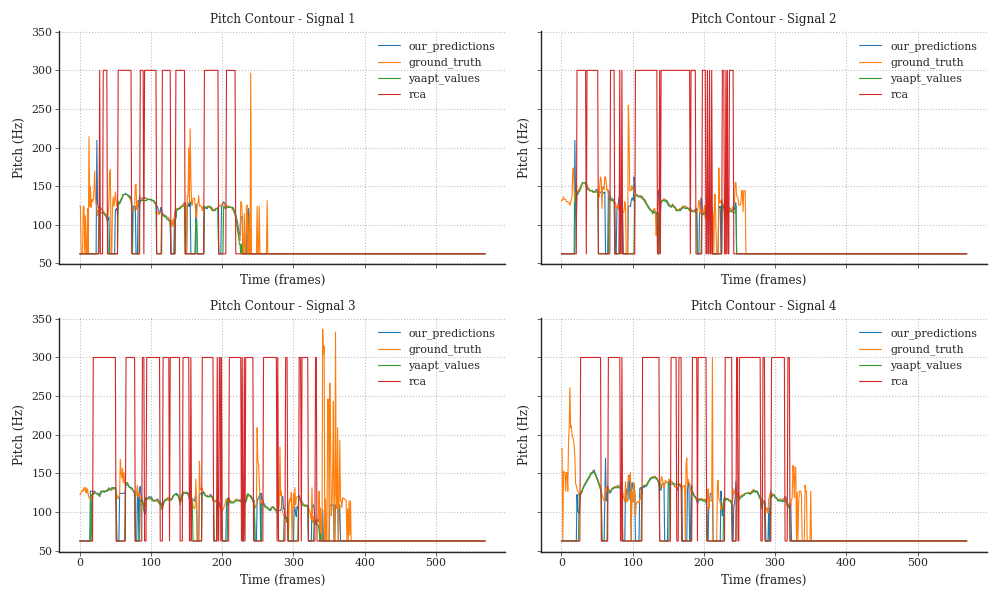

: 

In [7]:
def plot_pitch_line_subplots(**model_pitches):
    num_signals = len(list(model_pitches.values())[0])
    fig, axs = plt.subplots(num_signals//2, num_signals//2, figsize=(5*num_signals//2, 3*num_signals//2), sharex=True, sharey=True)
    axs = axs.flatten()
    
    for model_name, pitches in model_pitches.items():
        for i, pitch in enumerate(pitches):
            axs[i].plot(pitch, label=model_name)
            axs[i].set_title(f'Pitch Contour - Signal {i + 1}')
            axs[i].set_xlabel('Time (frames)')
            axs[i].set_ylabel('Pitch (Hz)')
            axs[i].grid(True)
            axs[i].legend()      
    
    plt.tight_layout()
    plt.show()


print("pitches_pridict shape",pitches_predicted.shape,
      "\nground truth shape" ,pitches_gt.shape,
      "\nground_truth min", pitches_gt.min(),
      "\nground truth max", pitches_gt.max(),
      "\npredict pitched min " ,pitches_predicted.min(),
      "\npredict pitched max ", pitches_predicted.max(),
      "\npitches_eval shape",pitches_eval.shape,
      "\npitches_eval min",pitches_eval.min(),
      "\npitches_eval max",pitches_eval.max(),
      "\nresult_max",result.max(),
        "\nresult_min",result.min()
      )


# Plotting each of the first 4 elements
#fig, axs = plt.subplots(4, 1, figsize=(10, 8))
plot_pitch_line_subplots(our_predictions=pitches_predicted, ground_truth=pitches_gt, yaapt_values=pitches_eval, rca=result)

for audio in corresponding_audio:
    display(Audio(audio.squeeze().numpy(), rate=16000))
    